Importation des library

In [18]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
from pathlib import Path

plt.style.use('dark_background')

Chargement des données

In [19]:
symbol = ['BTCUSDT']
time = "4h"
chemin = r'C:\Users\gunsa\Desktop\Git-Repo\Bot-Trading\Data\4h\BTCUSDT\BTCUSDT_4years_2022-01-01_TO_2025-12-26_4h_data'
data = pd.read_parquet(chemin)

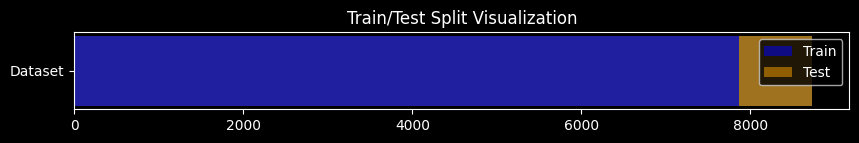

In [20]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.9*len(data))
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(data)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(data)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [21]:
df = data.copy()

open_ = df['Open']
high = df['High']
low = df['Low']
close = df['Close']
volume = df['Volume']

close = close.astype(np.float64).ffill()
high = high.astype(np.float64)
low = low.astype(np.float64)

In [22]:
# Paramètres
# RSI
# RSI
rsi_length = 14
rsi_overbought = 65
rsi_oversold = 35

# Pivots
lookback_left = 3
lookback_right = 3
window = lookback_left + lookback_right + 1

min_div_bars = 10
max_div_bars = 200

# Filtres
use_close_confirmation = True   # Pine: entryDelay
use_regular_div = True
use_hidden_div = True

# Risk management
stop_loss_pct = 0.03
take_profit_pct = 0.06

In [23]:
# Indicateurs
rsi = vbt.RSI.run(close, window=rsi_length).rsi


In [24]:
# Detection pivots
pivot_high_price = (
    high.shift(lookback_right) ==
    high.rolling(window).max()
)

pivot_low_price = (
    low.shift(lookback_right) ==
    low.rolling(window).min()
)

pivot_high_rsi = (
    rsi.shift(lookback_right) ==
    rsi.rolling(window).max()
)

pivot_low_rsi = (
    rsi.shift(lookback_right) ==
    rsi.rolling(window).min()
)



In [25]:
bullish_div = pd.Series(False, index=df.index)
hidden_bullish_div = pd.Series(False, index=df.index)


In [26]:
# focntion divergence
def divergence_indices(pivot_price, pivot_rsi):
    idx = np.where(pivot_price & pivot_rsi)[0]
    if len(idx) < 2:
        return [], [], []

    idx1 = idx[1:]
    idx2 = idx[:-1]
    bars_between = np.abs(idx1 - idx2)

    return idx1, idx2, bars_between


In [27]:
# Pour Divergences régulières

idx1, idx2, bars = divergence_indices(
    pivot_low_price.values,
    pivot_low_rsi.values
)

valid = (
    (low.iloc[idx1].values < low.iloc[idx2].values) &
    (rsi.iloc[idx1].values > rsi.iloc[idx2].values) &
    (bars >= min_div_bars) &
    (bars <= max_div_bars)
)

# ⚠️ Replacer le signal AU BAR DU PIVOT (TradingView)
signal_idx = idx1[valid] - lookback_right
signal_idx = signal_idx[signal_idx >= 0]

bullish_div.iloc[signal_idx] = True




In [28]:
# Pour Divergences cachées

idx1, idx2, bars = divergence_indices(
    pivot_low_price.values,
    pivot_low_rsi.values
)

valid = (
    (low.iloc[idx1].values > low.iloc[idx2].values) &
    (rsi.iloc[idx1].values < rsi.iloc[idx2].values) &
    (bars >= min_div_bars) &
    (bars <= max_div_bars)
)

signal_idx = idx1[valid] - lookback_right
signal_idx = signal_idx[signal_idx >= 0]

hidden_bullish_div.iloc[signal_idx] = True


In [29]:
# Conditions d'entrée long

long_entries = False

if use_regular_div:
    long_entries |= bullish_div

if use_hidden_div:
    long_entries |= hidden_bullish_div

In [30]:
if use_close_confirmation:
    long_entries = long_entries.shift(1)



In [31]:
# nettoyage

long_entries = (
    long_entries
    .reindex(close.index)
    .fillna(False)
    .astype(np.bool_)
)


C:\Users\gunsa\AppData\Local\Temp\ipykernel_4756\1377286852.py:6: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [32]:
# Backtest
portfolio = vbt.Portfolio.from_signals(
    close=close,
    entries=long_entries,
    sl_stop=stop_loss_pct,
    tp_stop=take_profit_pct,
    init_cash=1000,
    fees=0.001,
    direction='longonly'
)



In [33]:
print(portfolio.stats())
print("Trades:", portfolio.trades.count())
portfolio.plot().show()


Start                         2022-01-01 01:00:00+01:00
End                           2025-12-26 13:00:00+01:00
Period                               1455 days 16:00:00
Start Value                                      1000.0
End Value                                   1343.589683
Total Return [%]                              34.358968
Benchmark Return [%]                          85.825301
Max Gross Exposure [%]                            100.0
Total Fees Paid                              158.417061
Max Drawdown [%]                              36.746023
Max Drawdown Duration                 526 days 16:00:00
Total Trades                                         67
Total Closed Trades                                  67
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  44.776119
Best Trade [%]                                 9.552282
Worst Trade [%]                               -7

In [34]:
trades = portfolio.trades.records_readable

print("===== EMA 9/21 + ATR TP/SL (Long & Short) =====")

print(portfolio.stats())

def stats_by_direction(trades, direction_name):
    t = trades[trades['Direction'] == direction_name]
    wins = t[t['PnL'] > 0]
    
    return {
        "direction": direction_name,
        "trades": len(t),
        "wins": len(wins),
        "losses": len(t) - len(wins),
        "winrate_%": round(len(wins) / len(t) * 100, 2) if len(t) > 0 else 0,
        "total_pnl": round(t['PnL'].sum(), 2),
        "avg_pnl": round(t['PnL'].mean(), 2)
    }

long_stats  = stats_by_direction(trades, "Long")
short_stats = stats_by_direction(trades, "Short")

print(long_stats)
print(short_stats)

===== EMA 9/21 + ATR TP/SL (Long & Short) =====
Start                         2022-01-01 01:00:00+01:00
End                           2025-12-26 13:00:00+01:00
Period                               1455 days 16:00:00
Start Value                                      1000.0
End Value                                   1343.589683
Total Return [%]                              34.358968
Benchmark Return [%]                          85.825301
Max Gross Exposure [%]                            100.0
Total Fees Paid                              158.417061
Max Drawdown [%]                              36.746023
Max Drawdown Duration                 526 days 16:00:00
Total Trades                                         67
Total Closed Trades                                  67
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  44.776119
Best Trade [%]                                 9.552282
